In [4]:
from transformers import AutoModelForCausalLM, AutoProcessor, TextIteratorStreamer

model_id = "microsoft/Phi-3-vision-128k-instruct" 

model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")

# model = AutoModelForCausalLM.from_pretrained('microsoft/Phi-3-vision-128k-instruct', device_map="cuda", trust_remote_code=True, torch_dtype="auto", _attn_implementation="eager")

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True) 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
from PIL import Image 

messages = [ 
    {"role": "system", "content": "You are a helpful assistant."}, 
    {"role": "user", "content": "<|image_1|>\nWhat is shown in this image?"}
] 


image_url = "dogs-playing-in-grassy-field.jpg"
image = Image.open(image_url) 

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0") 

print(f">>> Prompt\n{prompt}")

>>> Prompt
<|system|>
You are a helpful assistant.<|end|>
<|user|>
<|image_1|>
What is shown in this image?<|end|>
<|assistant|>



In [12]:
generation_args = { 
    "max_new_tokens": 1000, 
    "temperature": 0.2, 
    "do_sample": True, 
} 

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 


generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, 
                                  skip_special_tokens=True, 
                                  clean_up_tokenization_spaces=False)[0]
print(f'>>> Response\n{response}')

>>> Response
The image shows two dogs playing with a purple toy in a grassy area with trees in the background.


In [58]:
#streaming
from threading import Thread
streamer = TextIteratorStreamer(processor.tokenizer,skip_prompt=True,skip_special_tokens=True,clean_up_tokenization_spaces=False)

# Run the generation in a separate thread, so that we can fetch the generated text in a non-blocking way.
generation_kwargs = dict(inputs, streamer=streamer, max_new_tokens=512, eos_token_id=processor.tokenizer.eos_token_id)
thread = Thread(target=model.generate, kwargs=generation_kwargs)
thread.start()

for text in streamer:
    print(text, end="", flush=True)

The image shows two dogs playing with a purple toy in a grassy area with trees in the background.

In [20]:
import torch
torch.cuda.empty_cache()

In [5]:
import requests

response = requests.post("http://127.0.0.1:8000/v1/chat/completions", json={
    "model": "lit",
    "stream": False,  # You can stream chunked response by setting this True
    "messages": [
      {
        "role": "system",
        "content": "You are a helpful assistant."
      },
      {
        "role": "user",
        "content": [
                {"type": "text", "text": "What's in this image?"},
                {
                    "type": "image_url",
                    "image_url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
                }
            ]
      }
    ]
  })

response.json()

{'id': 'chatcmpl-4ab8d9',
 'object': 'chat.completion',
 'created': 1716803361,
 'model': 'lit',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': ' The  image  shows  a  wooden   boardwalk  leading  through  a    lush,  green  field  with  tall    grasses.  The  sky  is  partly   cloudy  with  a  mix  of  blue  and  white   clouds.  There  are  trees  and   shrubs  in  the   background,  and  the  overall  scene  is   serene  and     natural.'},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 0, 'total_tokens': 0, 'completion_tokens': 0}}

In [2]:
from openai import OpenAI

client = OpenAI(
    base_url="http://127.0.0.1:8000/v1",
    api_key="lit",
)
response = client.chat.completions.create(
    model="phi-3-vision",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg",
                },
            ],
        },
    ],
)

print(response.choices[0].message.content)

 The  image  shows  a  wooden   boardwalk  leading  through  a    lush,  green  field  with  tall    grasses.  The  sky  is  partly   cloudy  with  a  mix  of  blue  and  white   clouds.  There  are  trees  and   shrubs  in  the   background,  and  the  overall  scene  is   serene  and     natural.


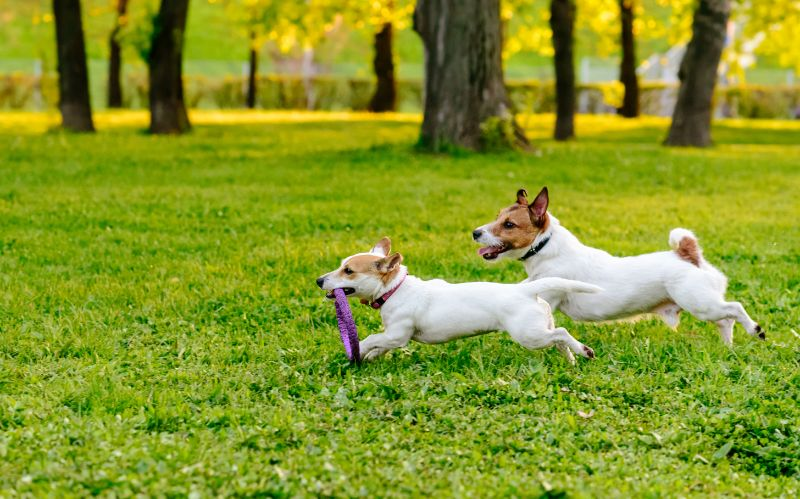

In [11]:
from PIL import Image 
image = Image.open("dogs-playing-in-grassy-field.jpg").convert("RGB")

image

In [20]:
from openai import OpenAI
from src.utils import encode_image

client = OpenAI(
    base_url="http://127.0.0.1:8000/v1",
    api_key="lit",
)
image_object = encode_image(image)
response = client.chat.completions.create(
    model="microsoft/Phi-3.5-vision-instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                image_object,
            ]
        },
    ],
)

print(response.choices[0].message.content)

The image shows two dogs playing with a purple toy in a grassy area with trees in the background.


: 

In [17]:
from openai import OpenAI
from src.utils import encode_image

client = OpenAI(
    base_url="http://127.0.0.1:8000/v1",
    api_key="lit",
)
stream_response = client.chat.completions.create(
    model="phi-3-vision",
    stream=True,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What’s in this image?"},
                {
                    "type": "image_url",
                    "image_url": encode_image(image),  # encodes to base64
                },
            ],
        },
    ],
)

for chunk in stream_response:
    print(chunk.choices[0].delta.content or "", end="")

The image shows two dogs playing with a purple toy in a grassy area with trees in the background.